<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Find_price_pattern_and_predict_on_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find price patterns

## Install packages

In [1]:
#optional installations: 
!pip install yfinance --upgrade --no-cache-dir
!pip3 install pandas_datareader

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


## Import packages

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel as C

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

## Get data

In [3]:
#@title Set symbol and time for get data
# ___variables___
ticker = "SNP" #@param {type:"string"}
#ticker = 'SNP'    # SINOPEC China Petroleum and Chemical Corp 
#ticker = 'CHA'    # China Telecom
#ticker = 'CHL'    # China Mobile
#ticker = 'NGG'    # National Grid

start_time = "2000-01-01" #@param {type:"date"}
start_time = datetime.datetime.strptime(start_time, "%Y-%m-%d")
# start_time = datetime.datetime(2019, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
# end_time = datetime.datetime.now().date().isoformat()         # today
end_time = datetime.datetime.now().date().strftime("%Y-%m-%d") #@param {type:"date"}

In [4]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date       High        Low       Open      Close      Volume  Adj Close
0 2000-10-18  16.057692  15.865385  15.865385  15.961538  15145260.0   6.223459
1 2000-10-19  15.576923  14.807692  15.384615  15.528846   1434680.0   6.054749
2 2000-10-20  15.673077  15.384615  15.480769  15.384615    263120.0   5.998515
3 2000-10-23  15.096154  14.278846  15.096154  14.903846    615940.0   5.811061
4 2000-10-24  14.759615  14.326923  14.615385  14.423077    674310.0   5.623607


## Polynomial fit
* high degree polynomials tend to oscillate significantly and will not correctly classify the dataset
* polynomials of low degree will not have local minima corresponding to double bottom

In [5]:
def polyfit(x_data, y_data, degree=80):
    # polynomial fit of degree xx
    pol = np.polyfit(x_data, y_data, degree)
    y_pol = np.polyval(pol, x_data)
    return y_pol

In [6]:
def gaussfit(x_data, y_data, max_len_per_fit=200):
    # Define kernel parameters. 
    l = 0.1
    sigma_f = 2
    # Error standard deviation. 
    sigma_n = 0.3

    # Define kernel object. 
    kernel = C(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
                * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

    # Define GaussianProcessRegressor object. 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=2)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(np.array(x_data).reshape(-1, 1), y_data)
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pol, sigma = gp.predict(np.array(x_data).reshape(-1, 1), return_std=True)
    return y_pol

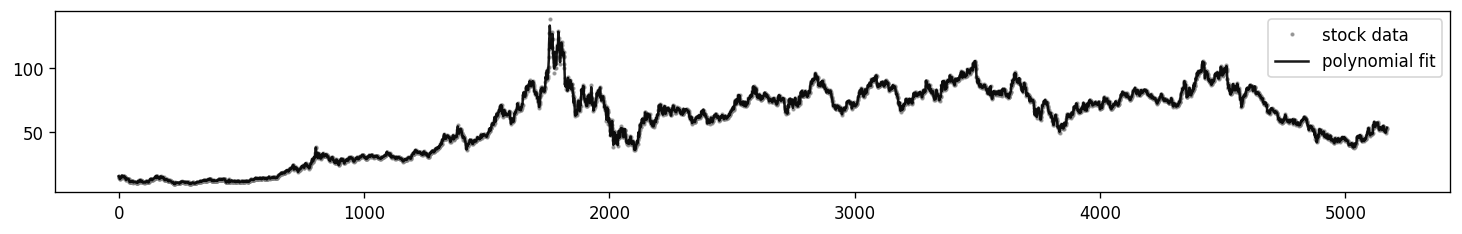

In [7]:
#@title Choose part of the OHLC (Open, High, Low, Close) dataset and fit it price
price_name = "Close" #@param ["Open", "High", "Low", "Close", "Adj Close"]

# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date
y_data = ticker_df[price_name]
# y_data = ticker_df['Low']

# # x values for the polynomial fit, 200 points
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# # polynomial fit of degree xx
# pol = np.polyfit(x_data, y_data, 80)
# y_pol = np.polyval(pol, x)
# y_pol = polyfit(x_data, y_data, 80)

# # Define kernel parameters. 
# l = 0.1
# sigma_f = 2
# # Error standard deviation. 
# sigma_n = 0.3

# # Define kernel object. 
# kernel = C(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
#             * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

# # Define GaussianProcessRegressor object. 
# gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)
# # Fit to data using Maximum Likelihood Estimation of the parameters
# gp.fit(np.array(x_data).reshape(-1, 1), y_data)
# # Make the prediction on the meshed x-axis (ask for MSE as well)
# y_pol, sigma = gp.predict(np.array(x_data).reshape(-1, 1), return_std=True)
y_pol = gaussfit(x_data, y_data)

#           ___ plotting ___
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')

# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)

# plot polynomial fit
plt.plot(x_data, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

## Detection of local extremes
Local minima are marked in red, local maxima are in blue. We will need only the minimums going forward.

In [8]:
def get_max_min(prices, smoothing, window_range, price_name='Adj Close'):
    smooth_prices = prices[price_name].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range][price_name].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range][price_name].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    # p = prices.reset_index()   
    # max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    # max_min = max_min.set_index('day_num')[price_name]
    
    return max_min

     date       Date       High  ...      Close    Volume  Adj Close
0      26 2000-11-24  15.288462  ...  15.288462   73060.0   5.961025
1      60 2001-01-16  11.442308  ...  11.057692  239720.0   4.311432
2      76 2001-02-07  10.807692  ...  10.769231  217620.0   4.198961
4      88 2001-02-26  13.023077  ...  12.923077   53560.0   5.038753
7     109 2001-03-27  11.153846  ...  11.000000  165750.0   4.288939
..    ...        ...        ...  ...        ...       ...        ...
535  5076 2020-12-22  43.680000  ...  43.310001  177300.0  43.310001
536  5095 2021-01-21  53.310001  ...  53.240002  126000.0  53.240002
537  5117 2021-02-23  58.400002  ...  58.230000  267900.0  58.230000
539  5139 2021-03-25  51.680000  ...  51.560001  136300.0  51.560001
540  5164 2021-04-30  50.259998  ...  49.189999  180700.0  49.189999

[295 rows x 8 columns]


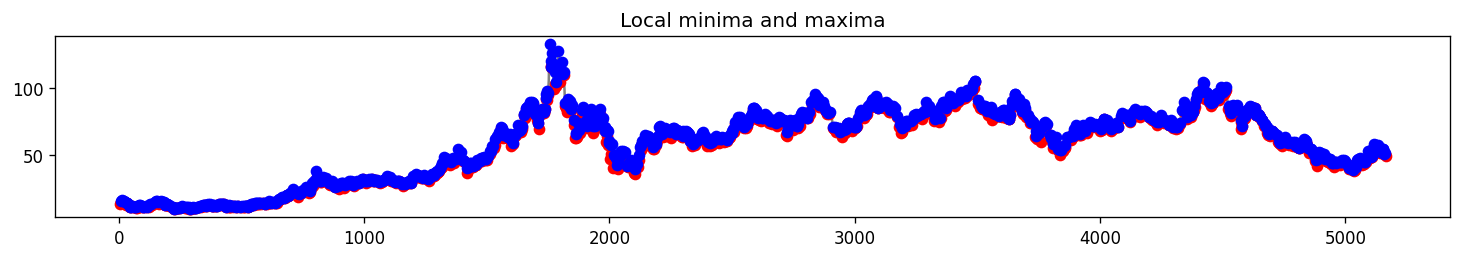

l_min:  [   5   11   18 ... 5158 5160 5164]


In [9]:
data = y_pol

#           ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
# +1 due to the fact that diff reduces the original index number
print(get_max_min(ticker_df, 20, 20, price_name=price_name))

# plot
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(x_data, data, color='grey')
plt.plot(x[l_min], data[l_min], "o", label="min", color='r')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='b')        # maxima
plt.title('Local minima and maxima')
plt.show()

print('l_min: ', l_min)

Position of local minima of the fitting function on x axis should correspond to x axis position of the minima in data. Since fitting function is just an approximation, it will be convenient to to use range of days (ticks) around the minimum. And then we would take an average value of the price for that x range to smooth the price values a bit. We will store the data in the dictionary.

In [10]:
#print('corresponding LOW values for suspected indeces: ')
#print(ticker_df.Low.iloc[l_min])

#extend the suspected x range:
delta = 10                                       # how many ticks to the left and to the right from local minimum on x axis

dict_i = dict()
dict_x = dict()

df_len = len(ticker_df.index)                    # number of rows in dataset

for element in l_min:                            # x coordinates of suspected minimums
    l_bound = element - delta                    # lower bound (left)
    u_bound = element + delta                    # upper bound (right)
    x_range = range(l_bound, u_bound + 1)        # range of x positions where we SUSPECT to find a low
    dict_x[element] = x_range                    # just helpful dictionary that holds suspected x ranges for further visualization strips
    
    #print('x_range: ', x_range)
    
    y_loc_list = list()
    for x_element in x_range:
        #print('-----------------')
        if x_element > 0 and x_element < df_len:                # need to stay within the dataframe
            #y_loc_list.append(ticker_df.Low.iloc[x_element])   # list of suspected y values that can be a minimum
            y_loc_list.append(ticker_df[price_name].iloc[x_element])
            #print(y_loc_list)
            #print('ticker_df.Low.iloc[x_element]', ticker_df.Low.iloc[x_element])
    dict_i[element] = y_loc_list                 # key in element is suspected x position of minimum
                                                 # to each suspected minimums we append the price values around that x position
                                                 # so 40: [53.70000076293945, 53.93000030517578, 52.84000015258789, 53.290000915527344]
                                                 # x position: [ 40$, 39$, 41$, 45$]
#print('DICTIONARY for l_min: ', dict_i)

Finally when we have x range and y price range identified we can compare the suspected low prices. Also, since we are looking for global minima we set a threshold that is in certain percentage range higher than the lowest datapoint in the dataset. This can be optionally improved by an average of several lowest values to mitigate impact of an outlier value.

## Find pattern

In [11]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.1 #@param {type:"number"}
def is_trend(x_data, y_data):
    if len(x_data) < 2:
        return False
    p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    err = res[0] if res.size > 0 else 0
    if err <= len(x_data) * trend_delta:
        return True
    return False

In [12]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
threshold = min(ticker_df[price_name]) * 1.15      # setting threshold higher than the global low

### Double top detection

In [13]:
#@title Double top detection

def find_key_points(x_data, y_data):
    key_points = [0]
    n = len(x_data)
    i = 0
    j = 2
    while j + 1 < n:
        p, res, _, _, _ = np.polyfit(x_data[i : j + 1], y_data[i : j + 1], 1, full=True)
        if res[0] > (j - i + 1) * trend_delta:
            key_points.append(j - 1)
            i = j - 1
        j += 1
    key_points.append(j - 1)
    # # ___ plotting ___
    # plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # # plot stock data
    # plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

    # # plot polynomial fit
    # plt.plot(np.array(x_data)[key_points], np.array(y_data)[key_points], '-', markersize=1.0, color='black', alpha=0.9)

    # plt.show()
    return key_points

# find_double_top(x_data, y_data)

l_min_max = sorted(np.append(l_min, l_max))
x_l_min_max = np.array(x_data)[l_min_max]
y_l_min_max = np.array(y_data)[l_min_max]

find_key_points(x_l_min_max, y_l_min_max)

def find_double_top(x_data, y_data, key_points):
    suspected_double_tops = list()
    # for i in range(1, len(key_points) - 2):
    #     for j in range(i + 1, len(key_points) - 1):
    #         l = key_points[i]
    #         r = key_points[j]
    #         if abs(y_data[l] - y_data[r]) <= y_delta \
    #             and y_data[l] >= max(data[l + 1: r]) \
    #             and y_data[r] >= max(data[l + 1: r]):
    #             k_min = l
    #             for k in range(l + 1, r):
    #                 if y_data[k] < y_data[k_min]:
    #                     k_min = k
    #             if (y_data[key_points[i - 1]] < y_data[k_min]) \
    #                 and y_data[key_points[j + 1]] < y_data[k_min]:
    #                 suspected_double_tops.append((i, j, k_min))
    assert len(x_data) == len(y_data)
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

find_double_top(x_data, y_pol, l_min_max)

[(8, 13, 18, 22, 25),
 (31, 33, 34, 35, 36),
 (31, 35, 37, 39, 41),
 (46, 47, 48, 50, 59),
 (49, 50, 51, 53, 59),
 (52, 53, 55, 56, 58),
 (60, 64, 66, 68, 69),
 (83, 84, 86, 88, 91),
 (111, 113, 115, 116, 117),
 (145, 151, 153, 156, 164),
 (169, 171, 174, 176, 178),
 (179, 180, 182, 183, 185),
 (187, 189, 190, 192, 199),
 (190, 192, 193, 195, 196),
 (190, 192, 196, 197, 199),
 (190, 195, 196, 197, 199),
 (236, 237, 238, 239, 240),
 (235, 239, 241, 242, 244),
 (232, 239, 246, 252, 287),
 (232, 242, 246, 252, 287),
 (250, 252, 254, 258, 268),
 (255, 258, 262, 264, 267),
 (250, 264, 269, 273, 283),
 (269, 273, 275, 279, 283),
 (250, 279, 284, 285, 287),
 (342, 343, 345, 347, 355),
 (346, 347, 348, 350, 352),
 (345, 350, 353, 354, 355),
 (360, 361, 362, 364, 367),
 (380, 381, 382, 383, 384),
 (380, 383, 384, 386, 388),
 (389, 390, 393, 396, 398),
 (388, 396, 398, 399, 401),
 (407, 408, 409, 411, 412),
 (405, 411, 415, 418, 420),
 (405, 411, 420, 427, 434),
 (405, 418, 420, 422, 434),
 (405

### Double bottom detection

In [14]:
def find_double_bottom(x_data, y_data, key_points):
    assert len(x_data) == len(y_data)
    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

find_double_bottom(x_data, y_pol, l_min_max)

[(44, 45, 47, 48, 49),
 (43, 48, 50, 51, 52),
 (65, 66, 68, 71, 78),
 (70, 71, 72, 76, 78),
 (90, 92, 94, 98, 124),
 (97, 98, 99, 101, 103),
 (97, 101, 105, 109, 111),
 (95, 109, 113, 122, 124),
 (177, 179, 180, 182, 183),
 (186, 187, 189, 190, 191),
 (192, 193, 195, 196, 197),
 (224, 226, 227, 228, 230),
 (214, 228, 258, 288, 331),
 (214, 228, 258, 291, 331),
 (244, 246, 248, 249, 250),
 (266, 269, 273, 284, 330),
 (273, 275, 279, 284, 319),
 (287, 288, 289, 291, 293),
 (286, 291, 293, 294, 295),
 (286, 294, 296, 298, 299),
 (280, 294, 302, 306, 318),
 (280, 294, 302, 308, 318),
 (280, 298, 302, 306, 318),
 (305, 306, 307, 308, 309),
 (304, 308, 310, 312, 314),
 (320, 324, 327, 328, 329),
 (332, 334, 337, 339, 342),
 (351, 353, 354, 356, 360),
 (354, 356, 357, 358, 360),
 (379, 380, 381, 382, 383),
 (379, 380, 383, 384, 385),
 (378, 380, 386, 388, 403),
 (379, 382, 383, 384, 385),
 (378, 384, 386, 388, 403),
 (386, 388, 390, 393, 402),
 (386, 388, 390, 398, 402),
 (386, 388, 390, 401,

In [15]:
# y_delta = 0.12                               # percentage distance between average lows
# threshold = min(ticker_df[price_name]) * 1.15      # setting threshold higher than the global low

# y_dict = dict()
# mini = list()
# suspected_bottoms = list()
#                                               #   BUG somewhere here
# for key in dict_i.keys():                     # for suspected minimum x position  
#     mn = sum(dict_i[key])/len(dict_i[key])    # this is averaging out the price around that suspected minimum
#                                               # if the range of days is too high the average will not make much sense
        
#     price_min = min(dict_i[key])
#     price_max_left = max(dict_i[key][:len(dict_i[key]) // 2])
#     price_max_right = max(dict_i[key][len(dict_i[key]) // 2:])
#     mini.append(price_min)                    # lowest value for price around suspected 
    
#     l_y = mn * (1.0 - y_delta)                #these values are trying to get an U shape, but it is kinda useless 
#     u_y = mn * (1.0 + y_delta)
#     y_dict[key] = [l_y, u_y, mn, price_min, price_max_left, price_max_right]
    
# #print('y_dict: ') 
# #print(y_dict) 

# #print('SCREENING FOR DOUBLE BOTTOM:')    
    
# for key_i in y_dict.keys():    
#     for key_j in y_dict.keys():    
#         if (key_i != key_j) and (y_dict[key_i][3] < threshold):
#             suspected_bottoms.append(key_i)

# suspected_double_bottoms = list()
# for i in range(max(y_dict.keys())):
#     if i in y_dict:
#         for j in range(i + 2, max(y_dict.keys())):
#             if j in y_dict and abs(data[i] - data[j]) <= y_delta and data[i] <= min(data[i + 1: j]) and data[j] <= min(data[i + 1: j]):
#                 k_max = i
#                 for k in range(i + 1, j):
#                     if data[k] > data[k_max]:
#                         k_max = k
#                 if (y_dict[i][4] > data[k_max]) and y_dict[j][5] > data[k_max]:
#                     suspected_double_bottoms.append((i, j, k_max))

### Inverse head and shoulder detection

In [16]:
def find_IHS_patterns(data, l_min, l_max):  
    patterns = list()
    
    i = 0  # index in l_min off first shoulder from left to right
    j = 0  # index in l_max off first point on neckle line fron left to right
    while i <= len(l_min) - 3 and j <= len(l_max) - 2:
        while j <= len(l_max) - 2 and  l_max[j] < l_min[i]:
            j += 1
        if j > len(l_max) - 2:
            break
        ia, ib, ic, id, ie = l_min[i], l_max[j], l_min[i + 1], l_max[j + 1], l_min[i + 2]
        a, b, c, d, e = data[ia], data[ib], data[ic], data[id], data[ie]
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
            patterns.append((ia, ib, ic, id, ie))
        i += 1
        
    return patterns

suspected_ihs = find_IHS_patterns(data, l_min, l_max)
print(suspected_ihs)

[(148, 151, 153, 156, 160), (262, 264, 269, 273, 275), (288, 289, 291, 293, 294), (353, 354, 356, 357, 358), (384, 386, 388, 390, 393), (415, 418, 420, 422, 423), (497, 504, 508, 510, 512), (562, 564, 566, 568, 570), (574, 576, 582, 588, 589), (637, 638, 640, 643, 645), (820, 821, 823, 824, 826), (1005, 1006, 1010, 1015, 1017), (1038, 1039, 1041, 1043, 1044), (1110, 1111, 1113, 1116, 1118), (1155, 1156, 1159, 1165, 1167), (1184, 1186, 1189, 1190, 1191), (1217, 1218, 1220, 1223, 1224), (1233, 1235, 1237, 1239, 1240), (1280, 1281, 1284, 1287, 1288), (1300, 1301, 1303, 1305, 1306), (1329, 1330, 1334, 1337, 1339), (1358, 1363, 1365, 1373, 1376), (1464, 1466, 1470, 1473, 1474), (1574, 1576, 1581, 1583, 1585), (1634, 1636, 1639, 1641, 1642), (1677, 1679, 1681, 1683, 1684), (1744, 1745, 1747, 1749, 1750), (1932, 1933, 1935, 1938, 1939), (1964, 1965, 1967, 1969, 1971), (1983, 1984, 1988, 1990, 1992), (2089, 2090, 2092, 2094, 2095), (2148, 2149, 2151, 2156, 2160), (2245, 2247, 2251, 2256, 2257)

### Final visualization

[5, 10, 11, 13, 18, 22, 25, 26, 30, 33, 34, 35, 37, 39, 45, 47, 48, 50, 51, 53, 55, 56, 60, 64, 66, 68, 71, 72, 76, 79, 82, 84, 86, 88, 92, 94, 98, 99, 101, 105, 109, 113, 115, 116, 122, 128, 129, 131, 136, 147, 148, 151, 153, 156, 160, 162, 166, 171, 174, 176, 179, 180, 182, 183, 187, 189, 190, 192, 193, 195, 196, 197, 204, 207, 217, 218, 220, 222, 226, 227, 228, 231, 232, 237, 238, 239, 241, 242, 246, 248, 249, 252, 254, 258, 262, 264, 269, 273, 275, 279, 284, 285, 288, 289, 291, 293, 294, 296, 298, 302, 306, 307, 308, 310, 312, 315, 316, 319, 324, 327, 328, 332, 334, 337, 339, 343, 345, 347, 348, 350, 353, 354, 356, 357, 358, 361, 362, 364, 367, 372, 380, 381, 382, 383, 384, 386, 388, 390, 393, 396, 398, 399, 401, 403, 404, 408, 409, 411, 415, 418, 420, 422, 423, 427, 429, 430, 437, 439, 441, 443, 448, 450, 452, 454, 455, 458, 460, 461, 466, 468, 469, 472, 477, 480, 482, 484, 486, 488, 493, 495, 497, 504, 508, 510, 512, 514, 516, 518, 519, 521, 523, 524, 526, 528, 529, 531, 532, 534

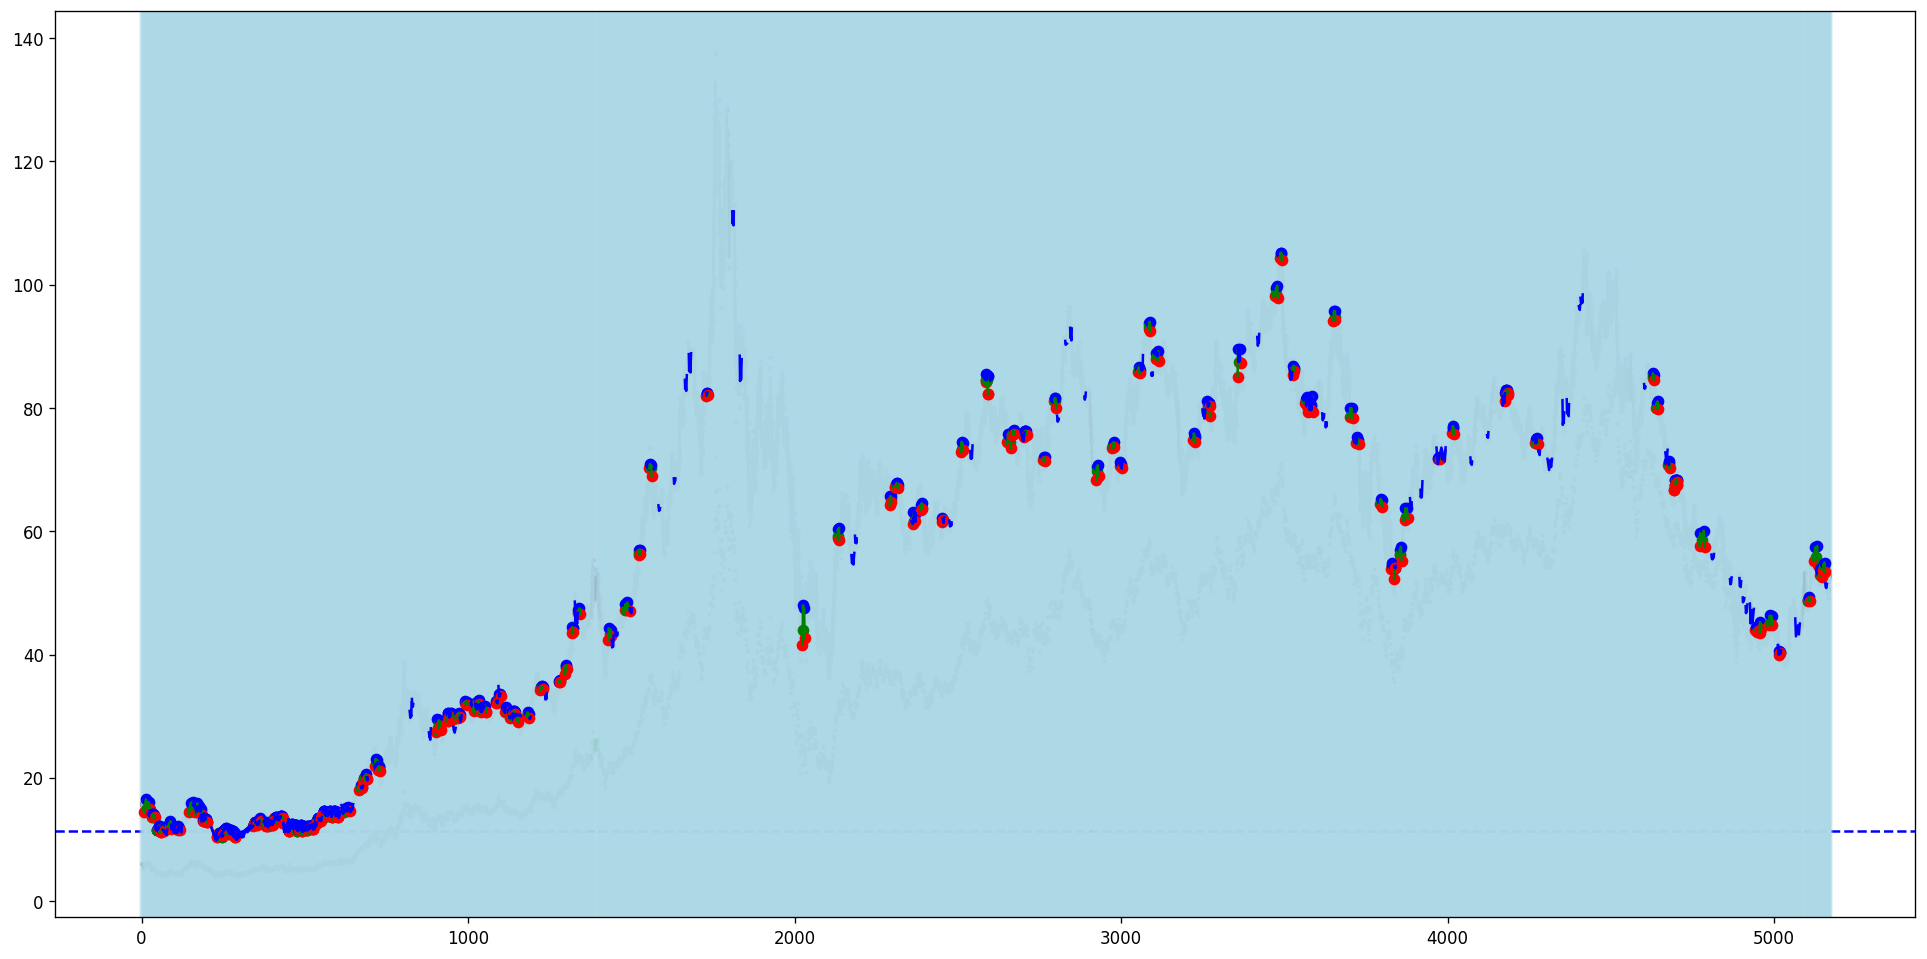

In [17]:
# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

# we can plot also all the other prices to get a price range for given day just for information
plt.plot(x_data, ticker_df['High'],      'o', markersize=1.5, color='blue',  alpha=0.7)
plt.plot(x_data, ticker_df['Open'],      'o', markersize=1.5, color='grey',  alpha=0.7)
plt.plot(x_data, ticker_df['Close'],     'o', markersize=1.5, color='red', alpha=0.7)    # Adj Close should be more accurate indication (accounts for dividends and stock splits)
plt.plot(x_data, ticker_df['Adj Close'], 'o', markersize=1.5, color='green', alpha=0.4)


# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)

# for position in suspected_bottoms:
#     plt.axvline(x=position, linestyle='-.', color='r')

# for bottom1, bottom2, top in suspected_double_bottoms:
#     plt.axvline(x=bottom1, linestyle='-.', color='b')
#     plt.axvline(x=top, linestyle='-.', color='g')
#     plt.axvline(x=bottom2, linestyle='-.', color='b')

# for ia, ib, ic, id, ie in suspected_ihs:
#     plt.axvline(x=ia, linestyle='-.', color='b')
#     plt.axvline(x=ib, linestyle='-.', color='g')
#     plt.axvline(x=ic, linestyle='-.', color='b')
#     plt.axvline(x=id, linestyle='-.', color='g')
#     plt.axvline(x=ie, linestyle='-.', color='b')
    
plt.axhline(threshold, linestyle='--', color='b')    


for key in dict_x.keys():
    #print('dict key value: ', dict_i[key])
    for value in dict_x[key]:
        plt.axvline(x=value, linestyle='-', color = 'lightblue', alpha=0.2)

l_min_max = sorted(np.append(l_min, l_max))
x_l_min_max = np.array(x_data)[l_min_max]
y_l_min_max = np.array(y_data)[l_min_max]
key_points = find_key_points(x_l_min_max, y_l_min_max)
key_points = np.array(l_min_max)[key_points]
# plt.plot(np.array(x_data)[key_points], np.array(y_data)[key_points], '-', markersize=1.0, color='b', alpha=0.9)

# suspected_double_tops = find_double_top(x_data, y_pol, key_points)
print(l_min_max)
suspected_double_tops = find_double_top(x_data, y_pol, l_min_max)
print(suspected_double_tops)

for istart, top1, bottom, top2, iend in suspected_double_tops:
    plt.plot(x_data[istart], y_pol[istart], "o", color='r')
    plt.plot(x_data[top1], y_pol[top1], "o", color='b')
    plt.plot(x_data[bottom], y_pol[bottom], "o", color='g')
    plt.plot(x_data[top2], y_pol[top2], "o", color='b')
    plt.plot(x_data[iend], y_pol[iend], "o", color='r')
    plt.plot(np.array(x_data)[[istart, top1, bottom, top2, iend]], np.array(y_pol)[[istart, top1, bottom, top2, iend]], "-", color='g')

suspected_double_bottoms = find_double_bottom(x_data, y_pol, l_min_max)
for istart, bot1, top, bot2, iend in suspected_double_bottoms:
    plt.plot(np.array(x_data)[[istart, bot1, top, bot2, iend]], np.array(y_pol)[[istart, bot1, top, bot2, iend]], "-", color='b')

plt.show()

# print('dict_x: ', dict_x)   # this dictionary is holding the values of the suspected low price
# print('y_dict:', y_dict)

- vertical red lines:            suspected double(multiple) minimums
- horizontal blue line:          price threshold for detection, we consider ONLY prices below this value
- vertical light blue strips:    areas around local minimums in polynomial fit

- green dots:                    'Adj Close' price, this might be shifted from rest of the price dataset (correction for stock splits and dividends), possibly even better for detecting double bottoms (needs to be tested further). In this notebook we used only 'Low' price.

So double (multiple) bottom is detected only when 'Low' price is below horizontal blue line and inside light blue strip. Position of the blue line threshold and width of the strip are set as constants.

# Predict with LSTM

## Import packages

In [18]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Get data at pattern for training

Find all patterns and sort by last index of pattern

In [19]:
suspected_double_tops = find_double_top(x_data, y_pol, l_min_max)
suspected_double_bottoms = find_double_bottom(x_data, y_pol, l_min_max)
suspected_patterns = suspected_double_tops + suspected_double_bottoms
suspected_patterns = sorted(suspected_patterns, key=lambda p: p[-1])
print(suspected_patterns)

[(8, 13, 18, 22, 25), (31, 33, 34, 35, 36), (31, 35, 37, 39, 41), (44, 45, 47, 48, 49), (43, 48, 50, 51, 52), (52, 53, 55, 56, 58), (46, 47, 48, 50, 59), (49, 50, 51, 53, 59), (60, 64, 66, 68, 69), (65, 66, 68, 71, 78), (70, 71, 72, 76, 78), (83, 84, 86, 88, 91), (97, 98, 99, 101, 103), (97, 101, 105, 109, 111), (111, 113, 115, 116, 117), (90, 92, 94, 98, 124), (95, 109, 113, 122, 124), (145, 151, 153, 156, 164), (169, 171, 174, 176, 178), (177, 179, 180, 182, 183), (179, 180, 182, 183, 185), (186, 187, 189, 190, 191), (190, 192, 193, 195, 196), (192, 193, 195, 196, 197), (187, 189, 190, 192, 199), (190, 192, 196, 197, 199), (190, 195, 196, 197, 199), (224, 226, 227, 228, 230), (236, 237, 238, 239, 240), (235, 239, 241, 242, 244), (244, 246, 248, 249, 250), (255, 258, 262, 264, 267), (250, 252, 254, 258, 268), (250, 264, 269, 273, 283), (269, 273, 275, 279, 283), (232, 239, 246, 252, 287), (232, 242, 246, 252, 287), (250, 279, 284, 285, 287), (287, 288, 289, 291, 293), (286, 291, 293, 

In [20]:
#@title Get data at patterns
pre_time_steps = 30 #@param {type:"integer"}

price_patterns_df = pd.DataFrame()
for pattern in suspected_patterns:
    last = pattern[-1]
    if last < pre_time_steps or last + 1 >= len(x_data):
        continue
    prices = np.array(y_data).reshape(-1, 1)[last - pre_time_steps + 1 : last + 2]
    price_patterns_df = price_patterns_df.append(pd.DataFrame(prices).T)

price_patterns_df.to_csv("{}_{}_{}_{}_data_patterns.txt"
                         .format(ticker, start_time, end_time, pre_time_steps),
                         sep=' ',
                         index=False,
                         header=False)

price_patterns_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,14.615385,14.423077,15.240385,15.528846,15.240385,15.673077,16.490385,16.250000,15.769231,15.576923,15.288462,14.903846,15.817308,15.673077,16.153847,16.057692,15.721154,15.528846,14.807692,15.288462,15.000000,14.230769,13.365385,13.028846,13.653846,14.038462,14.134615,14.086538,13.990385,13.942308,13.557692
0,15.673077,16.490385,16.250000,15.769231,15.576923,15.288462,14.903846,15.817308,15.673077,16.153847,16.057692,15.721154,15.528846,14.807692,15.288462,15.000000,14.230769,13.365385,13.028846,13.653846,14.038462,14.134615,14.086538,13.990385,13.942308,13.557692,13.798077,13.894231,13.750000,13.605769,13.173077
0,15.673077,16.153847,16.057692,15.721154,15.528846,14.807692,15.288462,15.000000,14.230769,13.365385,13.028846,13.653846,14.038462,14.134615,14.086538,13.990385,13.942308,13.557692,13.798077,13.894231,13.750000,13.605769,13.173077,12.307692,11.682692,11.442308,11.490385,11.634615,11.490385,11.682692,11.730769
0,15.721154,15.528846,14.807692,15.288462,15.000000,14.230769,13.365385,13.028846,13.653846,14.038462,14.134615,14.086538,13.990385,13.942308,13.557692,13.798077,13.894231,13.750000,13.605769,13.173077,12.307692,11.682692,11.442308,11.490385,11.634615,11.490385,11.682692,11.730769,11.682692,11.826923,12.259615
0,13.365385,13.028846,13.653846,14.038462,14.134615,14.086538,13.990385,13.942308,13.557692,13.798077,13.894231,13.750000,13.605769,13.173077,12.307692,11.682692,11.442308,11.490385,11.634615,11.490385,11.682692,11.730769,11.682692,11.826923,12.259615,12.067308,12.019231,12.115385,12.163462,11.586538,11.442308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,45.220001,44.599998,44.860001,45.860001,46.750000,47.529999,48.220001,48.009998,49.290001,50.490002,51.209999,50.740002,52.730000,53.009998,53.240002,51.470001,49.970001,49.119999,48.430000,48.750000,47.419998,48.049999,48.599998,48.939999,48.750000,49.160000,49.029999,49.439999,49.130001,48.709999,49.099998
0,48.750000,49.160000,49.029999,49.439999,49.130001,48.709999,49.099998,52.480000,55.570000,55.130001,54.000000,56.340000,58.230000,57.490002,57.119999,55.020000,54.919998,53.779999,55.599998,55.880001,57.200001,57.410000,56.349998,55.669998,56.080002,56.090000,57.650002,57.349998,56.410000,54.470001,53.290001
0,58.230000,57.490002,57.119999,55.020000,54.919998,53.779999,55.599998,55.880001,57.200001,57.410000,56.349998,55.669998,56.080002,56.090000,57.650002,57.349998,56.410000,54.470001,53.290001,52.790001,51.959999,52.270000,51.560001,53.080002,53.759998,53.490002,52.730000,53.720001,52.840000,52.919998,52.430000
0,56.349998,55.669998,56.080002,56.090000,57.650002,57.349998,56.410000,54.470001,53.290001,52.790001,51.959999,52.270000,51.560001,53.080002,53.759998,53.490002,52.730000,53.720001,52.840000,52.919998,52.430000,52.669998,51.799999,52.250000,53.630001,54.840000,54.119999,54.709999,54.880001,53.330002,51.470001


In [21]:
#@title Select scale method:
scale_method = "MinMax" #@param ["None", "MinMax"]


In [22]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
y_data_scaled = sc.fit_transform(np.array(y_data).reshape(-1, 1))
price_patterns_df_scaled = pd.DataFrame(sc.fit_transform(price_patterns_df.T).T,columns=price_patterns_df.columns)

In [23]:
X_train = []
y_train = []
# for pattern in suspected_patterns:
#     last = pattern[-1]
#     if last < pre_time_steps or last + 1 >= len(x_data):
#         continue
#     X_train.append(y_data_scaled[last - pre_time_steps + 1 : last + 1])
#     y_train.append(y_data_scaled[last + 1])
# if scale_method == 'None':
data = price_patterns_df.values
if scale_method == 'MinMax':
    # scs = []
    # price_patterns_scaled_df = price_patterns_df.copy()
    # for i, row in price_patterns_scaled_df.iterrows():
    #     print(i, row)
    #     sc = MinMaxScaler(feature_range = (0, 1))
    #     scaled_val = sc.fit_transform(np.array(row).reshape(-1, 1)).reshape(-1)
    #     print(i, scaled_val)
    #     price_patterns_scaled_df.loc[i] = scaled_val
    #     scs.append(sc)
    # data = price_patterns_scaled_df.values
    data = price_patterns_df_scaled.values
# separate into input and output columns
X_train, y_train = data[:, :-1], data[:, -1]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print(X_train)
print(y_train)

[[[0.45833346]
  [0.40277771]
  [0.63888897]
  ...
  [0.30555555]
  [0.27777795]
  [0.26388915]]

 [[0.76388873]
  [1.        ]
  [0.93055544]
  ...
  [0.25000007]
  [0.20833339]
  [0.16666671]]

 [[0.89795899]
  [1.        ]
  [0.97959156]
  ...
  [0.04081608]
  [0.01020402]
  [0.0510201 ]]

 ...

 [[1.        ]
  [0.88905576]
  [0.83358307]
  ...
  [0.32383815]
  [0.19190392]
  [0.20389763]]

 [[0.78964353]
  [0.67961112]
  [0.74595475]
  ...
  [0.52427147]
  [0.55177988]
  [0.30097096]]

 [[1.        ]
  [0.65357158]
  [0.44285718]
  ...
  [0.01428536]
  [0.00892844]
  [0.07678579]]]
[[0.15277764]
 [0.04166668]
 [0.06122432]
 [0.19101098]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03571441]
 [0.94451622]
 [0.94451622]
 [0.37857117]
 [0.2321429 ]
 [0.51200005]
 [0.15999964]
 [1.        ]
 [1.        ]
 [0.36430299]
 [0.327044  ]
 [0.34276733]
 [0.        ]
 [0.22443905]
 [0.22194527]
 [0.12718217]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.36363628]
 [0.4299362 ]
 [0.45248878]


## Build model

In [24]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Adam optimizer
opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
# # PiecewiseConstantDecay optimizer
# boundaries = [200, 800, 2000, 4000]
# values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
# opt = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# Compiling the RNN
model.compile(optimizer = opt, loss = 'mean_squared_error')
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 8000, batch_size = 512)

Streaming output truncated to the last 5000 lines.
Epoch 5501/8000
1/1 [==============================] - 0s 330ms/step - loss: 0.0020
Epoch 5502/8000
1/1 [==============================] - 0s 312ms/step - loss: 0.0021
Epoch 5503/8000
1/1 [==============================] - 0s 333ms/step - loss: 0.0022
Epoch 5504/8000
1/1 [==============================] - 0s 305ms/step - loss: 0.0024
Epoch 5505/8000
1/1 [==============================] - 0s 307ms/step - loss: 0.0022
Epoch 5506/8000
1/1 [==============================] - 0s 336ms/step - loss: 0.0030
Epoch 5507/8000
1/1 [==============================] - 0s 323ms/step - loss: 0.0023
Epoch 5508/8000
1/1 [==============================] - 0s 339ms/step - loss: 0.0023
Epoch 5509/8000
1/1 [==============================] - 0s 322ms/step - loss: 0.0026
Epoch 5510/8000
1/1 [==============================] - 0s 323ms/step - loss: 0.0025
Epoch 5511/8000
1/1 [==============================] - 0s 316ms/step - loss: 0.0021
Epoch 5512/8000
1/1 [====

## Test model

In [25]:
X_test = X_train

In [27]:
predicted_stock_price = model.predict(X_test)
if scale_method == 'MinMax':
    predicted_stock_price = sc.inverse_transform(predicted_stock_price.T).T
    y_train = sc.inverse_transform(y_train.T).T

In [28]:
y_train, predicted_stock_price

(array([[ 13.55769157],
        [ 13.17307663],
        [ 11.73076916],
        [ 12.25961494],
        [ 11.44230843],
        [ 11.05769157],
        [ 11.05769157],
        [ 11.15384579],
        [ 12.1769228 ],
        [ 12.1769228 ],
        [ 11.58461475],
        [ 11.26923084],
        [ 11.98461533],
        [ 11.30769157],
        [ 12.5       ],
        [ 12.5       ],
        [ 14.15384579],
        [ 14.50769234],
        [ 14.54615402],
        [ 13.26923084],
        [ 13.5       ],
        [ 13.49230766],
        [ 13.19999981],
        [ 12.3538456 ],
        [ 12.3538456 ],
        [ 12.3538456 ],
        [ 10.92307663],
        [ 10.88461494],
        [ 10.61538506],
        [ 11.30769157],
        [ 10.92307663],
        [ 11.04615402],
        [ 10.80769157],
        [ 10.80769157],
        [ 10.26923084],
        [ 10.26923084],
        [ 10.26923084],
        [ 10.29230785],
        [ 10.53846169],
        [ 10.83846188],
        [ 10.71538544],
        [ 10.961

In [29]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_train - predicted_stock_price)
print(max(y_train - predicted_stock_price))

[[0.08]
 [0.12]
 [0.06]
 [0.04]
 [-0.03]
 [0.03]
 [0.03]
 [0.03]
 [-0.03]
 [-0.03]
 [-0.01]
 [0.01]
 [-0.04]
 [0.04]
 [-0.01]
 [-0.01]
 [-0.01]
 [0.02]
 [0.07]
 [0.03]
 [-0.05]
 [0.06]
 [0.00]
 [0.03]
 [0.03]
 [0.03]
 [-0.00]
 [-0.00]
 [0.01]
 [-0.02]
 [-0.01]
 [0.02]
 [0.00]
 [0.00]
 [0.02]
 [0.02]
 [0.02]
 [-0.03]
 [0.00]
 [-0.05]
 [0.00]
 [0.01]
 [0.00]
 [0.00]
 [0.00]
 [-0.03]
 [0.01]
 [-0.01]
 [-0.01]
 [-0.01]
 [-0.00]
 [0.04]
 [0.00]
 [0.00]
 [-0.01]
 [-0.01]
 [-0.01]
 [0.01]
 [-0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.00]
 [-0.01]
 [-0.00]
 [-0.00]
 [-0.00]
 [-0.00]
 [-0.00]
 [0.00]
 [0.00]
 [-0.02]
 [-0.03]
 [-0.02]
 [-0.01]
 [-0.01]
 [-0.01]
 [-0.01]
 [-0.00]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [-0.00]
 [-0.01]
 [-0.01]
 [0.01]
 [0.01]
 [0.02]
 [0.01]
 [0.01]
 [0.01]
 [-0.00]
 [-0.02]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.03]
 [-0.01]
 [-0.01]
 [0.00]
 [0.02]
 [-0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [-0.01]
 [-0.02]
 [-0.01]
 [-0.01]
 [-0.0

In [30]:
X_train.shape

(342, 30, 1)